In [31]:
import numpy as np
import pandas as pd
import datetime as dt
import statsmodels.api as sm
import matplotlib.pyplot as plt
import scipy.optimize as optimize
from scipy.stats import norm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

import warnings
warnings.filterwarnings("ignore")

In [2]:
import rqdatac as rq
rq.init()

In [3]:
index_weight = pd.read_json("index_info.json")["weight"]
index_weight

PS    0.472150
V     0.139169
SF    0.154166
SA    0.060324
LC    0.132901
JM   -0.018898
MA    0.065181
AO   -0.007069
SP    0.059142
RU   -0.057066
Name: weight, dtype: float64

In [4]:
si_data = rq.futures.get_dominant_price("SI", frequency="1m").loc["SI"]
si_data

,trading_date,dominant_id,open,close,high,low,total_turnover,volume,open_interest
datetime,,,,,,,,,
2025-07-09 09:01:00,2025-07-09,SI2509,8240.0,8265.0,8275.0,8190.0,0,28120.0,387518.0
2025-07-09 09:02:00,2025-07-09,SI2509,8270.0,8285.0,8295.0,8235.0,0,22168.0,390274.0
2025-07-09 09:03:00,2025-07-09,SI2509,8285.0,8295.0,8315.0,8285.0,0,24679.0,393468.0
2025-07-09 09:04:00,2025-07-09,SI2509,8295.0,8270.0,8295.0,8260.0,0,15722.0,394521.0
2025-07-09 09:05:00,2025-07-09,SI2509,8270.0,8275.0,8295.0,8270.0,0,11545.0,395824.0
...,...,...,...,...,...,...,...,...,...
2025-09-30 14:56:00,2025-09-30,SI2511,8650.0,8650.0,8655.0,8640.0,0,1449.0,177551.0
2025-09-30 14:57:00,2025-09-30,SI2511,8645.0,8650.0,8655.0,8645.0,0,509.0,177262.0
2025-09-30 14:58:00,2025-09-30,SI2511,8655.0,8650.0,8655.0,8650.0,0,1153.0,176792.0


In [5]:
def preprocess(data: tuple):

    minute_price = data["close"]
    minute_price.loc[data["trading_date"].iloc[0] + pd.Timedelta(hours=9)] = data["open"].iloc[0]
    minute_price = minute_price.sort_index()
    trading_date = minute_price.index.strftime("%Y-%m-%d")
    mask = (minute_price.index >= pd.to_datetime(trading_date + " 09:00:00")) & \
           (minute_price.index <= pd.to_datetime(trading_date + " 15:00:00"))
    minute_price = minute_price[mask]

    return minute_price

In [50]:
def preprocess_vwap(data: tuple):

    minute_vwap = (data["close"] * data["volume"]).cumsum() / data["volume"].cumsum()
    minute_vwap.loc[data["trading_date"].iloc[0] + pd.Timedelta(hours=9)] = data["open"].iloc[0]
    minute_vwap = minute_vwap.sort_index()
    trading_date = minute_vwap.index.strftime("%Y-%m-%d")
    mask = (minute_vwap.index >= pd.to_datetime(trading_date + " 09:00:00")) & \
           (minute_vwap.index <= pd.to_datetime(trading_date + " 15:00:00"))
    minute_vwap = minute_vwap[mask]
    minute_vwap = minute_vwap / minute_vwap.iloc[0]

    return minute_vwap

In [7]:
si_minute = si_data.groupby("trading_date").apply(preprocess)
si_minute.name = "SI"
si_val = si_minute.groupby(level=0).apply(lambda x: (((x.diff() / x.shift()).fillna(0) + 1).cumprod())).droplevel(0)
si_val

trading_date  datetime           
2025-07-09    2025-07-09 09:00:00    1.000000
              2025-07-09 09:01:00    1.003034
              2025-07-09 09:02:00    1.005461
              2025-07-09 09:03:00    1.006675
              2025-07-09 09:04:00    1.003641
                                       ...   
2025-09-30    2025-09-30 14:56:00    1.004063
              2025-09-30 14:57:00    1.004063
              2025-09-30 14:58:00    1.004063
              2025-09-30 14:59:00    1.003482
              2025-09-30 15:00:00    1.002902
Name: SI, Length: 13560, dtype: float64

In [51]:
si_vwap = si_data.groupby("trading_date").apply(preprocess_vwap)
si_vwap

trading_date  datetime           
2025-07-09    2025-07-09 09:00:00    1.000000
              2025-07-09 09:01:00    1.003034
              2025-07-09 09:02:00    1.004104
              2025-07-09 09:03:00    1.004950
              2025-07-09 09:04:00    1.004723
                                       ...   
2025-09-30    2025-09-30 14:56:00    1.006419
              2025-09-30 14:57:00    1.006414
              2025-09-30 14:58:00    1.006401
              2025-09-30 14:59:00    1.006379
              2025-09-30 15:00:00    1.006340
Length: 13560, dtype: float64

In [9]:
all_minute = pd.DataFrame()
for underlying in index_weight.index:
    data = rq.futures.get_dominant_price(underlying, frequency="1m").loc[underlying]
    data.to_csv("data/%s.csv" % underlying.lower())
    minute = data.groupby("trading_date").apply(preprocess)
    minute.name = underlying
    all_minute = pd.concat([all_minute, minute], axis=1)

all_minute

PS       V      SF      SA       LC  \
2025-07-09 2025-07-09 09:00:00  38470.0  5037.0  5534.0  1275.0  64020.0   
           2025-07-09 09:01:00  38370.0  5067.0  5542.0  1279.0  64120.0   
           2025-07-09 09:02:00  38755.0  5067.0  5542.0  1278.0  64180.0   
           2025-07-09 09:03:00  38860.0  5068.0  5540.0  1277.0  64120.0   
           2025-07-09 09:04:00  38810.0  5065.0  5538.0  1276.0  64080.0   
...                                 ...     ...     ...     ...      ...   
2025-09-30 2025-09-30 14:56:00  50950.0  4848.0  5508.0  1263.0  73000.0   
           2025-09-30 14:57:00  51100.0  4847.0  5510.0  1264.0  72960.0   
           2025-09-30 14:58:00  51225.0  4845.0  5504.0  1260.0  72960.0   
           2025-09-30 14:59:00  51200.0  4841.0  5500.0  1257.0  72960.0   
           2025-09-30 15:00:00  51360.0  4839.0  5494.0  1255.0  72800.0   

                                    JM      MA      AO      SP       RU  
2025-07-09 2025-07-09 09:00:00   965.0  2461.0  3169.0  5100.0  14905.0  
           2025-07-09 09:01:00   969.0  2461.0  3174.0  5094.0  14915.0  
           2025-07-09 09:02:00   967.5  2460.0  3170.0  5096.0  14900.0  
           2025-07-09 09:03:00   969.0  2463.0  3169.0  5096.0  14915.0  
           2025-07-09 09:04:00   969.5  2462.0  3168.0  5094.0  14910.0  
...                                ...     ...     ...     ...      ...  
2025-09-30 2025-09-30 14:56:00  1132.0  2333.0  2880.0  4836.0  15110.0  
           2025-09-30 14:57:00  1130.0  2331.0  2880.0  4842.0  15110.0  
           2025-09-30 14:58:00  1129.5  2331.0  2876.0  4838.0  15090.0  
           2025-09-30 14:59:00  1127.0  2330.0  2869.0  4838.0  15060.0  
           2025-09-30 15:00:00  1126.0  2328.0  2868.0  4834.0  15030.0  

[13560 rows x 10 columns]

In [10]:
index_val = all_minute.groupby(level=0).apply(lambda x: (((x.diff() / x.shift()).apply(lambda y: y.dot(index_weight), axis=1)).fillna(0) + 1).cumprod()).droplevel(0)
index_val

2025-07-09  2025-07-09 09:00:00    1.000000
            2025-07-09 09:01:00    1.000024
            2025-07-09 09:02:00    1.004931
            2025-07-09 09:03:00    1.006011
            2025-07-09 09:04:00    1.005092
                                     ...   
2025-09-30  2025-09-30 14:56:00    0.989523
            2025-09-30 14:57:00    0.990951
            2025-09-30 14:58:00    0.991728
            2025-09-30 14:59:00    0.991275
            2025-09-30 15:00:00    0.992158
Length: 13560, dtype: float64

In [11]:
val_diff = index_val - si_val
counts, bin_edges = np.histogram(val_diff, bins=100)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

def normal_func(x, mu, sigma, amplitude):
    return amplitude * norm.pdf(x, mu, sigma)

# 使用曲线拟合
params, params_covariance = optimize.curve_fit(
    normal_func, bin_centers, counts, p0=[val_diff.mean(), val_diff.std(), counts.max()]
)

print(f"拟合参数: μ={params[0]:.6f}, σ={params[1]:.6f}, 幅度={params[2]:.6f}")

拟合参数: μ=0.001234, σ=0.010174, 幅度=11.463763


In [12]:
confidence_levels = [0.10, 0.20, 0.30]  # 10%, 20%, 30%水平

print("标准正态分布的单边分位数:")
for level in confidence_levels:
    z_score = norm.ppf(1 - level)  # ppf是分位数函数
    print(f"{int(level*100)}%水平: μ + {z_score:.4f}σ")

标准正态分布的单边分位数:
10%水平: μ + 1.2816σ
20%水平: μ + 0.8416σ
30%水平: μ + 0.5244σ


In [13]:
si_val.name = "si"
index_val.name = "index"
val_diff.name = "spread"

data = pd.concat([val_diff, si_val, index_val], axis=1)
data

spread        si     index
2025-07-09 2025-07-09 09:00:00  0.000000  1.000000  1.000000
           2025-07-09 09:01:00 -0.003010  1.003034  1.000024
           2025-07-09 09:02:00 -0.000530  1.005461  1.004931
           2025-07-09 09:03:00 -0.000664  1.006675  1.006011
           2025-07-09 09:04:00  0.001451  1.003641  1.005092
...                                  ...       ...       ...
2025-09-30 2025-09-30 14:56:00 -0.014540  1.004063  0.989523
           2025-09-30 14:57:00 -0.013111  1.004063  0.990951
           2025-09-30 14:58:00 -0.012335  1.004063  0.991728
           2025-09-30 14:59:00 -0.012207  1.003482  0.991275
           2025-09-30 15:00:00 -0.010744  1.002902  0.992158

[13560 rows x 3 columns]

In [14]:
def add_lag(data: pd.DataFrame):
    for lag in range(1, 3):
        data["si_lag_%d" % lag] = data["si"].shift(lag)
        data["index_lag_%d" % lag] = data["index"].shift(lag)
    return data

lag_data = data.groupby(level=0).apply(add_lag).droplevel(0).dropna(how="any")
lag_data

spread        si     index  si_lag_1  \
2025-07-09 2025-07-09 09:02:00 -0.000530  1.005461  1.004931  1.003034   
           2025-07-09 09:03:00 -0.000664  1.006675  1.006011  1.005461   
           2025-07-09 09:04:00  0.001451  1.003641  1.005092  1.006675   
           2025-07-09 09:05:00  0.002472  1.004248  1.006720  1.003641   
           2025-07-09 09:06:00  0.002917  1.006068  1.008985  1.004248   
...                                  ...       ...       ...       ...   
2025-09-30 2025-09-30 14:56:00 -0.014540  1.004063  0.989523  1.003482   
           2025-09-30 14:57:00 -0.013111  1.004063  0.990951  1.004063   
           2025-09-30 14:58:00 -0.012335  1.004063  0.991728  1.004063   
           2025-09-30 14:59:00 -0.012207  1.003482  0.991275  1.004063   
           2025-09-30 15:00:00 -0.010744  1.002902  0.992158  1.003482   

                                index_lag_1  si_lag_2  index_lag_2  
2025-07-09 2025-07-09 09:02:00     1.000024  1.000000     1.000000  
           2025-07-09 09:03:00     1.004931  1.003034     1.000024  
           2025-07-09 09:04:00     1.006011  1.005461     1.004931  
           2025-07-09 09:05:00     1.005092  1.006675     1.006011  
           2025-07-09 09:06:00     1.006720  1.003641     1.005092  
...                                     ...       ...          ...  
2025-09-30 2025-09-30 14:56:00     0.990118  1.003482     0.989981  
           2025-09-30 14:57:00     0.989523  1.003482     0.990118  
           2025-09-30 14:58:00     0.990951  1.004063     0.989523  
           2025-09-30 14:59:00     0.991728  1.004063     0.990951  
           2025-09-30 15:00:00     0.991275  1.004063     0.991728  

[13440 rows x 7 columns]

In [30]:
X = lag_data.drop(["spread", "si", "index"], axis=1)
X = sm.add_constant(X)
y = lag_data["si"]
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                     si   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                 3.149e+05
Date:                Thu, 09 Oct 2025   Prob (F-statistic):               0.00
Time:                        08:57:17   Log-Likelihood:                 67455.
No. Observations:               13440   AIC:                        -1.349e+05
Df Residuals:                   13435   BIC:                        -1.349e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0019      0.001      1.699      

In [16]:
(val_diff.groupby(level=0).apply(lambda x: adfuller(x)[1]) < 0.05).sum()

13

In [17]:
((si_val - si_vwap).fillna(method="bfill").groupby(level=0).apply(lambda x: adfuller(x)[1]) < 0.05).sum()

10

In [ ]:
syn_index = index_val * 0.2 + si_vwap * 
syn_diff = syn_index - si_val
syn_index.corr(si_val)

0.8644386194159142

In [18]:
def daily_series(panel: pd.DataFrame, diff: bool=False):
    all_daily = pd.DataFrame()
    for data in panel.groupby(level=0):
        daily = data[1].droplevel(0)
        daily.name = daily.index[0].strftime("%Y%m%d")
        daily.index = daily.index.map(lambda x: x.strftime("%H%M%S"))
        all_daily = pd.concat([all_daily, daily], axis=1)
    if diff:
        all_daily = all_daily.diff().dropna()
    return all_daily.reset_index(drop=True)

In [19]:
def long_data_export(all_daily: pd.DataFrame):
    all_daily_long = all_daily.stack().reset_index()
    all_daily_long.columns = ["time", "date", "value"]
    all_daily_long["date"] = pd.to_datetime(all_daily_long["date"])
    all_daily_long = all_daily_long.sort_values(by=["date", "time"]).reset_index(drop=True)
    all_daily_long.to_csv("si_daily_minute.csv")

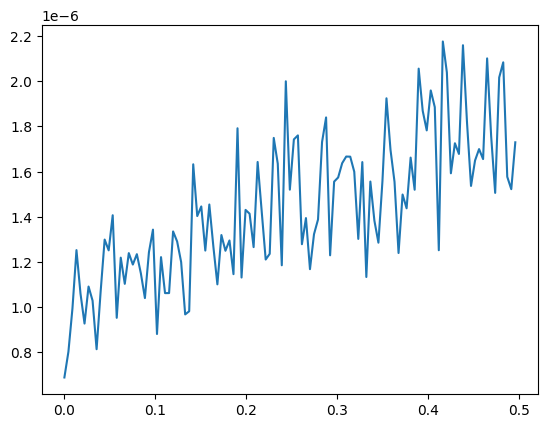

In [58]:
panel = daily_series(syn_diff)

def spectral_analysis(series: pd.Series):
    fft_result = np.fft.fft(series.diff().dropna())
    n = len(panel.index)
    freq = np.fft.fftfreq(n)
    psd = np.abs(fft_result) ** 2 / n
    return pd.Series(psd[: n//2], index=freq[: n//2])

average_spectral_power = panel.apply(spectral_analysis).mean(axis=1)
plt.plot(average_spectral_power)
plt.show()

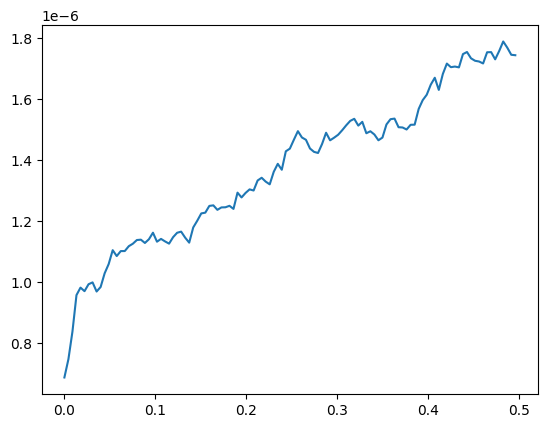

In [59]:
plt.plot(average_spectral_power.ewm(span=20, ignore_na=True).mean())
plt.show()

In [44]:
model = ARIMA(val_diff, order=(1, 0, 1))
print(model.fit().summary())

                               SARIMAX Results                                
Dep. Variable:                 spread   No. Observations:                13560
Model:                 ARIMA(1, 0, 1)   Log Likelihood               67964.942
Date:                Thu, 09 Oct 2025   AIC                        -135921.883
Time:                        10:04:28   BIC                        -135891.824
Sample:                             0   HQIC                       -135911.860
                              - 13560                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.002      0.173      0.863      -0.003       0.004
ar.L1          0.9923      0.001    755.984      0.000       0.990       0.995
ma.L1         -0.0651      0.003    -25.089      0.0